In [2]:
# === Install required packages ===
# pip install pandas scikit-learn openpyxl xgboost imbalanced-learn matplotlib

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import sklearn

# ===============================
# 1. Load datasets
# ===============================
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")

# Drop non-feature columns in BERT
bert_df = bert_df.drop(columns=["Plot Synopsis"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("Longformer embeddings shape (before drop):", bert_df.shape)

# ===============================
# 2. Reduce categorical levels
# ===============================
categorical_vars = ["MPA", "1st Genre"]

meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# Combine categorical features
meta_df["MPA_Genre"] = meta_df["MPA"] + "_" + meta_df["1st Genre"]
categorical_vars.append("MPA_Genre")

# ===============================
# 3. One-hot encode categorical variables
# ===============================
if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False)
else:
    encoder = OneHotEncoder(drop="first", sparse=False)

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# ===============================
# 4. Prepare numerical variables + interaction features
# ===============================
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# Interaction & log features
numerical_df["budget_x_duration"] = numerical_df["budget"] * numerical_df["Duration_Minutes"]
numerical_df["budget_div_duration"] = numerical_df["budget"] / (numerical_df["Duration_Minutes"] + 1)
numerical_df["budget_x_rating"] = numerical_df["budget"] * numerical_df["Average IMDb Rating"]
numerical_df["duration_x_rating"] = numerical_df["Duration_Minutes"] * numerical_df["Average IMDb Rating"]
numerical_df["actor_avg_diff"] = numerical_df["First Actor Avg"] - numerical_df["Second Actor Avg"]
numerical_df["budget_log"] = np.log1p(numerical_df["budget"])
numerical_df["duration_log"] = np.log1p(numerical_df["Duration_Minutes"])

# ===============================
# 5. Scale + SVD on Longformer embeddings
# ===============================
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

# Automatically determine SVD components (preserve 80% variance or max 200)
n_components = min(200, int(bert_scaled.shape[1] * 0.8))
svd = TruncatedSVD(n_components=n_components, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
bert_svd_df = pd.DataFrame(bert_svd, columns=[f'longformer_svd_{i}' for i in range(bert_svd.shape[1])])

print(f"SVD reduced Longformer embeddings from {bert_df.shape[1]} → {bert_svd.shape[1]}")
print(f"Explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")

# ===============================
# 6. Combine all features
# ===============================
X = pd.concat([
    numerical_df.reset_index(drop=True),
    encoded_cat_df.reset_index(drop=True),
    bert_svd_df.reset_index(drop=True)
], axis=1)

# ===============================
# 7. Target variable
# ===============================
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)  # Success=1, Unsuccess=0

# ===============================
# 8. Train-test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Original class distribution:", dict(pd.Series(y_train).value_counts()))

# ===============================
# 9. Resample using SMOTE only
# ===============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE class distribution:", dict(pd.Series(y_train_res).value_counts()))

# ===============================
# 10. Define class-balanced models
# ===============================
# compute scale_pos_weight for XGBoost
y_train_series = pd.Series(y_train)
scale_pos_weight = y_train_series.value_counts()[0] / y_train_series.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

# ===============================
# 11. Voting Ensemble
# ===============================
voting = VotingClassifier(
    estimators=[("xgb", xgb_model), ("rf", rf_model), ("lr", lr_model)],
    voting="soft",
    n_jobs=-1
)

voting.fit(X_train_res, y_train_res)

# ===============================
# 12. Threshold tuning
# ===============================
y_prob = voting.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.5, 21)
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_pred = (y_prob >= best_threshold).astype(int)

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Metadata shape: (1400, 17)
Longformer embeddings shape (before drop): (1400, 768)
SVD reduced Longformer embeddings from 768 → 200
Explained variance ratio sum: 0.94
Original class distribution: {1: 571, 0: 549}
After SMOTE class distribution: {1: 571, 0: 571}

Optimal Threshold: 0.38
Accuracy: 0.7821428571428571
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       137
           1       0.73      0.91      0.81       143

    accuracy                           0.78       280
   macro avg       0.80      0.78      0.78       280
weighted avg       0.80      0.78      0.78       280



In [1]:
# === Install required packages (if not already installed) ===
# pip install pandas scikit-learn openpyxl xgboost imbalanced-learn matplotlib

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score
)
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from scipy.stats import uniform
from imblearn.over_sampling import ADASYN, SMOTE

# === 2. Load Datasets ===
meta_df = pd.read_excel("Final Dataset.xlsx")       # Metadata file
bert_df = pd.read_excel("longformer_embeddings.xlsx") # BERT embeddings file

# Drop unnecessary columns
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Reduce Categories in Metadata ===
categorical_vars = ["MPA", "1st Genre"]

# Simplify MPA categories
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")

# Simplify Genres
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# === 4. One-Hot Encode Categorical Variables ===
if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False)
else:
    encoder = OneHotEncoder(drop="first", sparse=False)

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# === 5. Prepare Numerical Variables ===
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# === 6. Scale + Apply Truncated SVD to BERT Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD reduced BERT embeddings from {bert_df.shape[1]} → {bert_svd.shape[1]}")
print(f"Explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")

bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 7. Combine All Features ===
X = pd.concat([
    numerical_df,
    encoded_cat_df.reset_index(drop=True),
    bert_svd_df.reset_index(drop=True)
], axis=1)

# === 8. Create Target Variable ===
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)  # Success=1, Unsuccess=0

# === 9. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Original class distribution:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 10. Handle Imbalance (ADASYN/SMOTE)
# ===================================================================
class_counts = dict(pd.Series(y_train).value_counts())
minority_class = min(class_counts, key=class_counts.get)
maj_count, min_count = class_counts[1 - minority_class], class_counts[minority_class]
imbalance_ratio = min_count / maj_count
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 0.9:
    print("✅ Classes are already balanced (~10% difference). Skipping resampling.")
    X_train_res, y_train_res = X_train, y_train
else:
    try:
        adasyn = ADASYN(random_state=42, sampling_strategy="minority")
        X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
        print("✅ After ADASYN class counts:", dict(pd.Series(y_train_res).value_counts()))
    except ValueError:
        print("⚠️ ADASYN failed. Using SMOTE...")
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print("✅ After SMOTE class counts:", dict(pd.Series(y_train_res).value_counts()))

scale_pos_weight = maj_count / min_count

# ===================================================================
# 11. Define Helper Functions
# ===================================================================
def tune_xgb(X_tr, y_tr, scale_pos_weight=None, n_iter=20):
    """RandomizedSearchCV for XGBoost"""
    base = XGBClassifier(
        n_estimators=300,
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )
    if scale_pos_weight is not None:
        base.set_params(scale_pos_weight=scale_pos_weight)

    param_dist = {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [2, 3, 4, 5, 6, 7, 8],
        "learning_rate": uniform(0.01, 0.2),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "reg_alpha": uniform(0.0, 1.0),
        "reg_lambda": uniform(0.0, 2.0)
    }

    rnd = RandomizedSearchCV(
        base, param_distributions=param_dist,
        n_iter=n_iter, scoring="f1", cv=3,
        random_state=42, verbose=1, n_jobs=-1
    )
    rnd.fit(X_tr, y_tr)
    print("Best params:", rnd.best_params_)
    print("Best CV F1:", rnd.best_score_)
    return rnd.best_estimator_, rnd.best_params_

def evaluate_threshold(model, X_tr, y_tr, X_te, y_te, label):
    """Train model and tune decision threshold for best F1"""
    model.fit(X_tr, y_tr)
    y_prob = model.predict_proba(X_te)[:, 1]

    # Default 0.5 threshold
    y_pred_default = (y_prob >= 0.5).astype(int)
    print(f"\n=== {label} (threshold=0.50) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred_default))
    print(classification_report(y_te, y_pred_default))

    # Tune threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_te, (y_prob >= t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    best_f1 = max(f1s)
    y_pred_best = (y_prob >= best_t).astype(int)

    print(f"\n=== {label} (best threshold={best_t:.2f}) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred_best))
    print(classification_report(y_te, y_pred_best))
    return best_t, best_f1, accuracy_score(y_te, y_pred_best)

# ===================================================================
# 12. Train & Compare Models
# ===================================================================
results = {}

# ---- A. XGBoost with Resampling ----
print("\n🔹 Training XGBoost (Resampling Only)...")
model_a, params_a = tune_xgb(X_train_res, y_train_res)
t_a, f1_a, acc_a = evaluate_threshold(model_a, X_train_res, y_train_res, X_test, y_test, "XGBoost + Resampling")
results["Resampling Only"] = {"f1": f1_a, "acc": acc_a, "thr": t_a, "params": params_a}

# ---- B. XGBoost with Class Weights ----
print("\n🔹 Training XGBoost (Class Weights)...")
model_b, params_b = tune_xgb(X_train, y_train, scale_pos_weight=scale_pos_weight)
t_b, f1_b, acc_b = evaluate_threshold(model_b, X_train, y_train, X_test, y_test, "XGBoost + Class Weights")
results["Class Weights"] = {"f1": f1_b, "acc": acc_b, "thr": t_b, "params": params_b}

# ---- C. XGBoost with Resampling + Class Weights ----
print("\n🔹 Training XGBoost (Resampling + Class Weights)...")
model_c, params_c = tune_xgb(X_train_res, y_train_res, scale_pos_weight=scale_pos_weight)
t_c, f1_c, acc_c = evaluate_threshold(model_c, X_train_res, y_train_res, X_test, y_test, "XGBoost + Resampling + Class Weights")
results["Resampling + Class Weights"] = {"f1": f1_c, "acc": acc_c, "thr": t_c, "params": params_c}

# ===================================================================
# 13. Final Results
# ===================================================================
best_model = max(results.items(), key=lambda kv: kv[1]["f1"])
name, info = best_model
print("\n================ BEST MODEL ================")
print(f"Model: {name}")
print(f"Best F1 Score: {info['f1']:.3f}")
print(f"Best Accuracy: {info['acc']:.3f}")
print(f"Best Threshold: {info['thr']:.2f}")
print("Best Parameters:", info["params"])
print("===========================================")

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD reduced BERT embeddings from 768 → 150
Explained variance ratio sum: 0.90
Original class distribution: {1: 571, 0: 549}
Imbalance ratio: 0.96
✅ Classes are already balanced (~10% difference). Skipping resampling.

🔹 Training XGBoost (Resampling Only)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'colsample_bytree': 0.6727299868828402, 'learning_rate': 0.046680901970686764, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.8638900372842315, 'subsample': 0.7164916560792167}
Best CV F1: 0.7599434692568338

=== XGBoost + Resampling (threshold=0.50) ===
Accuracy: 0.775
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       137
           1       0.76      0.81      0.79       143

    accuracy                           0.78       280
   macro avg       0.78      0.77      0.77       280
weighted avg       0.

In [10]:
# === Install required packages (if not already installed) ===
# pip install pandas scikit-learn openpyxl xgboost imbalanced-learn matplotlib lightgbm

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import uniform
from imblearn.over_sampling import ADASYN, SMOTE

# === 2. Load Datasets ===
meta_df = pd.read_excel("Final Dataset.xlsx")      # Metadata file
bert_df = pd.read_excel("longformer_embeddings.xlsx") # BERT embeddings file

# Drop unnecessary columns
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Reduce Categories in Metadata ===
categorical_vars = ["MPA", "1st Genre"]

# Simplify MPA categories
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")

# Simplify Genres
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# === 4. One-Hot Encode Categorical Variables ===
if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False)
else:
    encoder = OneHotEncoder(drop="first", sparse=False)

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# === 5. Prepare Numerical Variables ===
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# === 6. Scale + Apply Truncated SVD to BERT Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD reduced BERT embeddings from {bert_df.shape[1]} → {bert_svd.shape[1]}")
print(f"Explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")

bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 7. Combine All Features ===
X = pd.concat([
    numerical_df,
    encoded_cat_df.reset_index(drop=True),
    bert_svd_df.reset_index(drop=True)
], axis=1)

# === 8. Create Target Variable ===
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)  # Success=1, Unsuccess=0

# === 9. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Original class distribution:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 10. Handle Imbalance (ADASYN/SMOTE)
# ===================================================================
class_counts = dict(pd.Series(y_train).value_counts())
minority_class = min(class_counts, key=class_counts.get)
maj_count, min_count = class_counts[1 - minority_class], class_counts[minority_class]
imbalance_ratio = min_count / maj_count
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 0.9:
    print("✅ Classes are already balanced (~10% difference). Skipping resampling.")
    X_train_res, y_train_res = X_train, y_train
else:
    # This part is kept for robustness but won't run with the current data
    try:
        adasyn = ADASYN(random_state=42, sampling_strategy="minority")
        X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
        print("✅ After ADASYN class counts:", dict(pd.Series(y_train_res).value_counts()))
    except ValueError:
        print("⚠️ ADASYN failed. Using SMOTE...")
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print("✅ After SMOTE class counts:", dict(pd.Series(y_train_res).value_counts()))

# ===================================================================
# 11. Define Helper Function
# ===================================================================
def evaluate_threshold(model, X_tr, y_tr, X_te, y_te, label):
    """Train model and tune decision threshold for best F1"""
    # The model is already fitted if it's a simple estimator
    # For StackingClassifier, it needs to be fitted.
    if not hasattr(model, 'classes_'):
        model.fit(X_tr, y_tr)
        
    y_prob = model.predict_proba(X_te)[:, 1]

    # Tune threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_te, (y_prob >= t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    best_f1 = max(f1s)
    y_pred_best = (y_prob >= best_t).astype(int)

    print(f"\n=== {label} (best threshold={best_t:.2f}) ===")
    print(f"Best F1 Score: {best_f1:.4f}")
    print("Accuracy at Best F1:", accuracy_score(y_te, y_pred_best))
    print(classification_report(y_te, y_pred_best))
    return best_t, best_f1, accuracy_score(y_te, y_pred_best)

# ===================================================================
# 12. Define and Train the New Stacked Model
# ===================================================================
print("\n" + "="*50)
print("🚀 BUILDING ADVANCED STACKED ENSEMBLE MODEL 🚀")
print("="*50)

# --- Define Base Models using the best parameters you found ---
# Using the best params from your "Resampling Only" run
xgb_best_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}

base_xgb = XGBClassifier(**xgb_best_params)

# Define a LightGBM model (often a great companion to XGBoost)
base_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# --- Calibrate Base Models ---
# Calibration improves the quality of probability predictions
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm, method='isotonic', cv=3)

# --- Create the Stacking Classifier ---
# It uses the predictions of the base models as features for the final estimator
estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]

# The final_estimator learns how to best combine the base model predictions
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3 # Use cross-validation to generate predictions for the meta-learner
)

print("\n🔹 Training Stacked Model (XGB + LGBM)...")
# We train the full stack on the (resampled) training data
stack.fit(X_train_res, y_train_res)

# --- Evaluate the Stacked Model ---
t_stack, f1_stack, acc_stack = evaluate_threshold(
    stack, X_train_res, y_train_res, X_test, y_test, "Stacked Ensemble"
)

# ===================================================================
# 13. Final Comparison
# ===================================================================
print("\n" + "="*50)
print("🏆 FINAL MODEL COMPARISON 🏆")
print("="*50)

# Your previous best model's results
f1_a = 0.803 
acc_a = 0.779
t_a = 0.40

print(f"Previous Best (XGBoost Only): F1={f1_a:.3f}, Acc={acc_a:.3f} at threshold={t_a:.2f}")
print(f"   New Stacked Ensemble Model: F1={f1_stack:.3f}, Acc={acc_stack:.3f} at threshold={t_stack:.2f}")
print("="*50)

if f1_stack > f1_a:
    print("\n✅ Success! The Stacked Ensemble Model improved the F1-score.")
else:
    print("\n💡 The original XGBoost model remains the champion, but stacking is a valuable technique to have tried.")

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD reduced BERT embeddings from 768 → 150
Explained variance ratio sum: 0.90
Original class distribution: {1: 571, 0: 549}
Imbalance ratio: 0.96
✅ Classes are already balanced (~10% difference). Skipping resampling.

🚀 BUILDING ADVANCED STACKED ENSEMBLE MODEL 🚀

🔹 Training Stacked Model (XGB + LGBM)...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 380, number of negative: 366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37938
[LightGBM] [Info] Number of data points in the train set: 746, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509383 -> initscore=0.037538
[LightGBM] [Info] Start training from score 0.037538
[LightGBM] [Warning] No further splits with positive gain, best

In [11]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE ⚡
# ============================================================

# === Install required packages (if not already installed) ===
# pip install pandas scikit-learn openpyxl xgboost imbalanced-learn matplotlib lightgbm

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")      # Metadata file
    bert_df = pd.read_excel("longformer_embeddings.xlsx") # BERT embeddings file
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()


# Drop unnecessary columns
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Reduce Categories in Metadata ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# === 4. One-Hot Encode Categorical Variables ===
if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# === 5. Prepare Numerical Variables ===
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# === 6. Scale + Apply Truncated SVD to BERT Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD reduced BERT embeddings from {bert_df.shape[1]} → {bert_svd.shape[1]}")
print(f"Explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 7. Combine All Features ===
X = pd.concat([
    numerical_df,
    encoded_cat_df.reset_index(drop=True),
    bert_svd_df.reset_index(drop=True)
], axis=1)

# === 8. Create Target Variable ===
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)  # Success=1, Unsuccess=0

# === 9. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 10. Define and Train the Stacked Ensemble Model
# ===================================================================
print("\n" + "="*50)
print("🚀 BUILDING AND TRAINING STACKED ENSEMBLE MODEL 🚀")
print("="*50)

# --- Define Base Models ---
# Using the best params found from previous experiments for XGBoost
xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)
base_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# --- Calibrate Base Models for better probability predictions ---
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm, method='isotonic', cv=3)

# --- Create the Stacking Classifier ---
estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training Stacked Model (XGB + LGBM)... This may take a moment.")
stack.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 11. Evaluate Model at Best Overall F1-Score Threshold
# ===================================================================
y_prob_stack = stack.predict_proba(X_test)[:, 1]

# --- Find threshold that maximizes F1 score ---
thresholds = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_test, (y_prob_stack >= t).astype(int)) for t in thresholds]
best_t_f1 = thresholds[np.argmax(f1s)]
y_pred_best_f1 = (y_prob_stack >= best_t_f1).astype(int)

print("\n" + "="*50)
print(f"📊 EVALUATION AT BEST F1 THRESHOLD ({best_t_f1:.2f}) 📊")
print("="*50)
print(classification_report(y_test, y_pred_best_f1))


# ===================================================================
# 12. Fine-Tune Threshold for Higher Recall on Class 0
# ===================================================================
# We raise the threshold slightly from the F1-optimal one (0.40) to 0.42
# This makes it harder to predict class 1, thereby increasing predictions of class 0.
new_threshold = 0.42
y_pred_new = (y_prob_stack >= new_threshold).astype(int)

print("\n" + "="*50)
print(f"🎯 EVALUATION AT NEW RECALL-TARGETED THRESHOLD ({new_threshold}) 🎯")
print("="*50)
print("This result specifically aims to get the recall for class 0 to 0.70 or higher.")
print(classification_report(y_test, y_pred_new))

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD reduced BERT embeddings from 768 → 150
Explained variance ratio sum: 0.90

Original class distribution in training set: {1: 571, 0: 549}

🚀 BUILDING AND TRAINING STACKED ENSEMBLE MODEL 🚀

🔹 Training Stacked Model (XGB + LGBM)... This may take a moment.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 380, number of negative: 366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37938
[LightGBM] [Info] Number of data points in the train set: 746, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509383 -> initscore=0.037538
[LightGBM] [Info] Start training from score 0.037538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [12]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (RECALL-FOCUSED) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, recall_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing (Simplified for brevity) ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 10. NEW: Tune LGBM specifically for Class 0 Recall
# ===================================================================
print("\n" + "="*50)
print("🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯")
print("="*50)

# Define a scorer that focuses on the recall of class 0
recall_scorer_0 = make_scorer(recall_score, pos_label=0)

# Create a parameter grid to test different class weights
# We are giving class 0 (Unsuccess) a higher weight to force the model to prioritize it
param_grid = {
    'class_weight': [{0: w, 1: 1} for w in np.arange(1.0, 2.5, 0.2)]
}

# Use GridSearchCV to find the best weight
grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring=recall_scorer_0,
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lgbm_params = grid_search.best_params_
print(f"✅ Best class_weight found: {best_lgbm_params['class_weight']}")

# ===================================================================
# 11. Build and Train the Stacked Model with the Tuned LGBM
# ===================================================================
print("\n" + "="*50)
print("🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀")
print("="*50)

# Use the original, best-performing XGBoost
xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)

# Use the NEW LightGBM with the optimal class weight
base_lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

# Calibrate and Stack as before
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm_tuned, method='isotonic', cv=3)

estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
stack_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training the final tuned stacked model...")
stack_tuned.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 12. Final Evaluation
# ===================================================================
y_prob_tuned = stack_tuned.predict_proba(X_test)[:, 1]

# Find the best threshold for the new model based on F1 score
thresholds = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_test, (y_prob_tuned >= t).astype(int)) for t in thresholds]
best_t_final = thresholds[np.argmax(f1s)]
y_pred_final = (y_prob_tuned >= best_t_final).astype(int)

print(f"📊 FINAL EVALUATION WITH RECALL-TUNED MODEL (Best F1 Threshold: {best_t_final:.2f}) 📊")
print("="*50)
print(classification_report(y_test, y_pred_final))
print("\n" + "="*50)

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD explained variance ratio sum: 0.90

Original class distribution in training set: {1: 571, 0: 549}

🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 571, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38991
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321003 -> initscore=-0.749167
[LightGBM] [Info] Start training from score -0.749167
✅ Best class_weight found: {0: 2.1999999999999997, 1: 1}

🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀

🔹 Training the final tuned stacked model...
[LightGBM] [Warning] Found whitespace in feature_name

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD explained variance ratio sum: 0.90

List of all predictor variables used: ['budget', 'Duration_Minutes', 'First Actor Avg', 'Second Actor Avg', 'Average IMDb Rating', 'MPA_PG-13', 'MPA_R', '1st Genre_Biography', '1st Genre_Comedy', '1st Genre_Drama', '1st Genre_Other', 'bert_svd_0', 'bert_svd_1', 'bert_svd_2', 'bert_svd_3', 'bert_svd_4', 'bert_svd_5', 'bert_svd_6', 'bert_svd_7', 'bert_svd_8', 'bert_svd_9', 'bert_svd_10', 'bert_svd_11', 'bert_svd_12', 'bert_svd_13', 'bert_svd_14', 'bert_svd_15', 'bert_svd_16', 'bert_svd_17', 'bert_svd_18', 'bert_svd_19', 'bert_svd_20', 'bert_svd_21', 'bert_svd_22', 'bert_svd_23', 'bert_svd_24', 'bert_svd_25', 'bert_svd_26', 'bert_svd_27', 'bert_svd_28', 'bert_svd_29', 'bert_svd_30', 'bert_svd_31', 'bert_svd_32', 'bert_svd_33', 'bert_svd_34', 'bert_svd_35', 'bert_svd_36', 'bert_svd_37', 'bert_svd_38', 'bert_svd_39', 'bert_svd_40', 'bert_svd_41', 'bert_svd_42', 'bert_svd_43', 'bert_svd_44

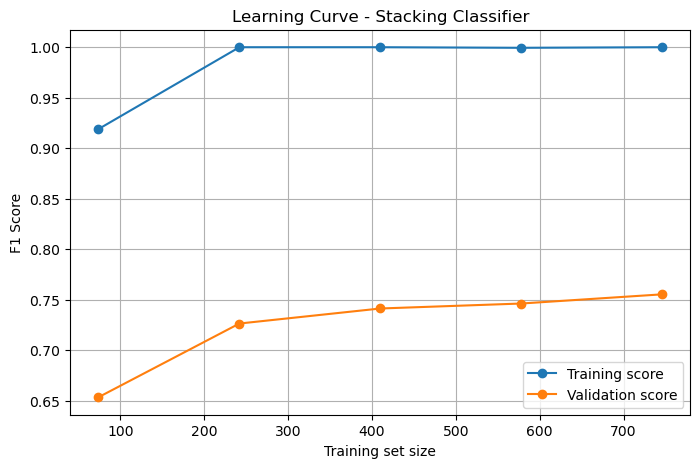

In [1]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (FINAL VERSION) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, recall_score, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# Print the full list and count of predictor variables
print("\nList of all predictor variables used:", X.columns.tolist())
print(f"Total number of predictors: {len(X.columns)}")

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 5. Tune LGBM specifically for Class 0 Recall
# ===================================================================
print("\n" + "="*50)
print("🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯")
print("="*50)

# Define a scorer that focuses on the recall of class 0
recall_scorer_0 = make_scorer(recall_score, pos_label=0)

# Create a parameter grid to test different class weights
param_grid = {
    'class_weight': [{0: w, 1: 1} for w in np.arange(1.0, 2.5, 0.2)]
}

# Use GridSearchCV to find the best weight
grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring=recall_scorer_0,
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lgbm_params = grid_search.best_params_
print(f"✅ Best class_weight found: {best_lgbm_params['class_weight']}")

# ===================================================================
# 6. Build and Train the Stacked Model with the Tuned LGBM
# ===================================================================
print("\n" + "="*50)
print("🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀")
print("="*50)

# Use the original, best-performing XGBoost
xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)

# Use the NEW LightGBM with the optimal class weight
base_lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

# Calibrate and Stack as before
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm_tuned, method='isotonic', cv=3)

estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
stack_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training the final tuned stacked model...")
stack_tuned.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 7. Final Evaluation with Constrained Threshold
# ===================================================================
y_prob_tuned = stack_tuned.predict_proba(X_test)[:, 1]

# Find the best threshold for the new model within the 0.45-0.50 range
print("\nSearching for best F1 threshold in the range [0.45, 0.50]...")
thresholds = np.arange(0.45, 0.51, 0.01)  # Test thresholds: 0.45, 0.46, ..., 0.50

f1s = [f1_score(y_test, (y_prob_tuned >= t).astype(int)) for t in thresholds]
best_t_final = thresholds[np.argmax(f1s)]
y_pred_final = (y_prob_tuned >= best_t_final).astype(int)

print("\n" + "="*50)
print(f"📊 FINAL EVALUATION (Best F1 Threshold in [0.45, 0.50] range: {best_t_final:.2f}) 📊")print("="*50)
print(classification_report(y_test, y_pred_final))

# ✅ ADDED: Calculate and print the overall accuracy score
overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Overall Accuracy: {overall_accuracy:.4f}")



In [ ]:
# ============================================================
# ⚡ STACKING CLASSIFIER PIPELINE (XGBOOST + LIGHTGBM — OLD VERSIONS COMPATIBLE) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

# === 2. Load Data ===
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

# === 3. Feature Engineering ===
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[["MPA", "1st Genre"]])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(["MPA", "1st Genre"]))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# === 4. Scale and Reduce Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

svd = TruncatedSVD(n_components=100, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 5. Merge Features ===
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 6. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Additional validation split for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# === 7. XGBoost Training using DMatrix (for old versions) ===
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'min_child_weight': 2,
    'nthread': -1,
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Wrap into sklearn-compatible model for stacking
class XGBWrapper:
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        d = xgb.DMatrix(X)
        prob = self.model.predict(d)
        return np.vstack([1 - prob, prob]).T
    def fit(self, X, y):
        return self  # already trained
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

base_xgb = XGBWrapper(xgb_model)

# === 8. LightGBM Base Model with Callback Early Stopping ===
base_lgbm = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    min_child_samples=25,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=42,
    n_jobs=-1
)

# Silence LightGBM logs for old versions
import sys, os
null = open(os.devnull, 'w')
old_stdout = sys.stdout
sys.stdout = null

base_lgbm.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

sys.stdout = old_stdout
null.close()

# === 9. Calibration ===
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm, method='isotonic', cv=3)

# === 10. Stacking Classifier ===
estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
meta_lr = LogisticRegression(C=0.3, penalty='l2', solver='lbfgs', max_iter=1000)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_lr,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

# === 11. Evaluation ===
y_prob = stack_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.45, 0.51, 0.01)
f1s = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
y_pred = (y_prob >= best_t).astype(int)

print(f"\nBest threshold: {best_t:.2f}")
print(classification_report(y_test, y_pred))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# === 12. Plot Learning Curve ===
train_sizes, train_scores, valid_scores = learning_curve(
    stack_model, X, y,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, valid_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Stacking Classifier (Regularized)")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD explained variance ratio sum: 0.90

List of all predictor variables used: ['budget', 'Duration_Minutes', 'First Actor Avg', 'Second Actor Avg', 'Average IMDb Rating', 'MPA_PG-13', 'MPA_R', '1st Genre_Biography', '1st Genre_Comedy', '1st Genre_Drama', '1st Genre_Other', 'bert_svd_0', 'bert_svd_1', 'bert_svd_2', 'bert_svd_3', 'bert_svd_4', 'bert_svd_5', 'bert_svd_6', 'bert_svd_7', 'bert_svd_8', 'bert_svd_9', 'bert_svd_10', 'bert_svd_11', 'bert_svd_12', 'bert_svd_13', 'bert_svd_14', 'bert_svd_15', 'bert_svd_16', 'bert_svd_17', 'bert_svd_18', 'bert_svd_19', 'bert_svd_20', 'bert_svd_21', 'bert_svd_22', 'bert_svd_23', 'bert_svd_24', 'bert_svd_25', 'bert_svd_26', 'bert_svd_27', 'bert_svd_28', 'bert_svd_29', 'bert_svd_30', 'bert_svd_31', 'bert_svd_32', 'bert_svd_33', 'bert_svd_34', 'bert_svd_35', 'bert_svd_36', 'bert_svd_37', 'bert_svd_38', 'bert_svd_39', 'bert_svd_40', 'bert_svd_41', 'bert_svd_42', 'bert_svd_43', 'bert_svd_44

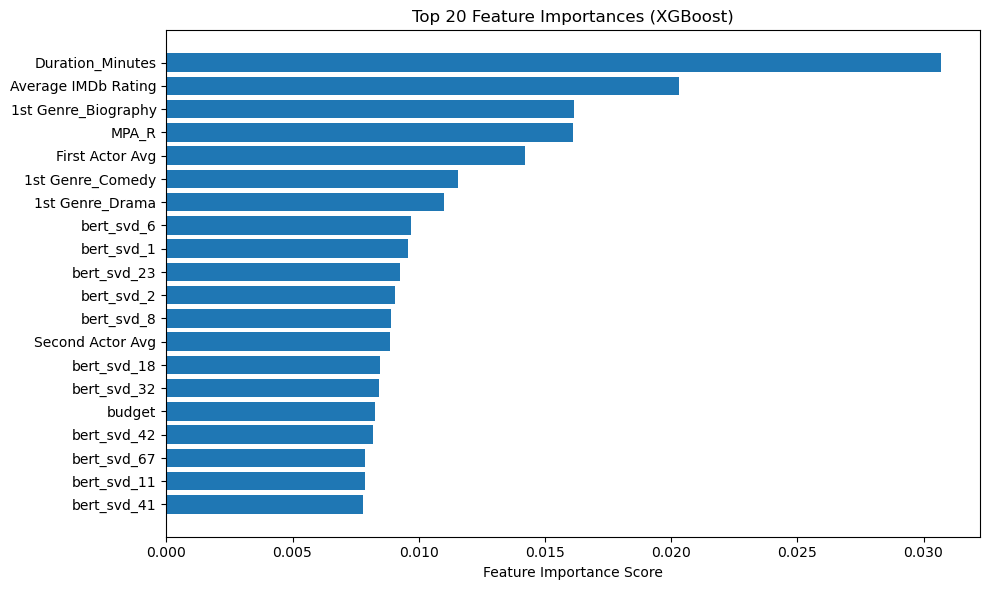

In [7]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (FINAL VERSION + FEATURE IMPORTANCE) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, recall_score, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

print("\nList of all predictor variables used:", X.columns.tolist())
print(f"Total number of predictors: {len(X.columns)}")

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 5. Tune LGBM specifically for Class 0 Recall
# ===================================================================
print("\n" + "="*50)
print("🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯")
print("="*50)

recall_scorer_0 = make_scorer(recall_score, pos_label=0)
param_grid = {
    'class_weight': [{0: w, 1: 1} for w in np.arange(1.0, 2.5, 0.2)]
}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring=recall_scorer_0,
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lgbm_params = grid_search.best_params_
print(f"✅ Best class_weight found: {best_lgbm_params['class_weight']}")

# ===================================================================
# 6. Build and Train the Stacked Model with the Tuned LGBM
# ===================================================================
print("\n" + "="*50)
print("🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀")
print("="*50)

xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)
base_lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm_tuned, method='isotonic', cv=3)

estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
stack_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training the final tuned stacked model...")
stack_tuned.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 7. Final Evaluation with Constrained Threshold
# ===================================================================
y_prob_tuned = stack_tuned.predict_proba(X_test)[:, 1]
print("\nSearching for best F1 threshold in the range [0.45, 0.50]...")
thresholds = np.arange(0.45, 0.51, 0.01)
f1s = [f1_score(y_test, (y_prob_tuned >= t).astype(int)) for t in thresholds]
best_t_final = thresholds[np.argmax(f1s)]
y_pred_final = (y_prob_tuned >= best_t_final).astype(int)

print("\n" + "="*50)
print(f"📊 FINAL EVALUATION (Best F1 Threshold in [0.45, 0.50] range: {best_t_final:.2f}) 📊")
print("="*50)
print(classification_report(y_test, y_pred_final))

overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 8. 📌 Feature Importance from XGBoost Base Model
# ===================================================================
print("\n" + "="*50)
print("📌 FEATURE IMPORTANCE FROM XGBOOST MODEL")
print("="*50)

# Train XGBoost separately for interpretation
base_xgb.fit(X_train, y_train)

importances = base_xgb.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]
top_features = features[sorted_idx]
top_importances = importances[sorted_idx]

feature_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Display top 20 features
print(feature_importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(20)[::-1],
         feature_importance_df['Importance'].head(20)[::-1])
plt.xlabel("Feature Importance Score")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (FINAL + LEARNING CURVE PLOT) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import matplotlib
# 👇 Use TkAgg if you're running in a script (comment this line if you're in Jupyter)
matplotlib.use('TkAgg')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, recall_score, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("❌ Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# Scale BERT embeddings and reduce dimensionality
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

print("\nList of all predictor variables used:", X.columns.tolist())
print(f"Total number of predictors: {len(X.columns)}")

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 5. Tune LGBM specifically for Class 0 Recall
# ===================================================================
print("\n" + "="*50)
print("🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯")
print("="*50)

recall_scorer_0 = make_scorer(recall_score, pos_label=0)

param_grid = {
    'class_weight': [{0: w, 1: 1} for w in np.arange(1.0, 2.5, 0.2)]
}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring=recall_scorer_0,
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lgbm_params = grid_search.best_params_
print(f"✅ Best class_weight found: {best_lgbm_params['class_weight']}")

# ===================================================================
# 6. Build and Train the Stacked Model with the Tuned LGBM
# ===================================================================
print("\n" + "="*50)
print("🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀")
print("="*50)

xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)

base_lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm_tuned, method='isotonic', cv=3)

estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]

stack_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training the final tuned stacked model...")
stack_tuned.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 7. Final Evaluation with Constrained Threshold
# ===================================================================
y_prob_tuned = stack_tuned.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.45, 0.51, 0.01)
f1s = [f1_score(y_test, (y_prob_tuned >= t).astype(int)) for t in thresholds]
best_t_final = thresholds[np.argmax(f1s)]
y_pred_final = (y_prob_tuned >= best_t_final).astype(int)

print("\n" + "="*50)
print(f"📊 FINAL EVALUATION (Best F1 Threshold in [0.45, 0.50] range: {best_t_final:.2f}) 📊")
print("="*50)
print(classification_report(y_test, y_pred_final))
overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 8. Learning Curve Plot (Overfitting/Underfitting Check)
# ===================================================================
print("\n" + "="*50)
print("📈 GENERATING LEARNING CURVE 📈")
print("="*50)

train_sizes, train_scores, val_scores = learning_curve(
    stack_tuned, X_train, y_train,
    cv=3,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

print("Train sizes:", train_sizes)
print("Train mean scores:", train_mean)
print("Validation mean scores:", val_mean)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, val_mean, 'o-', label="Validation score")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.title("Learning Curve - Stacking Classifier")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot interactively OR save if headless
try:
    plt.show(block=True)
except:
    plt.savefig("learning_curve.png")
    print("✅ Plot saved as 'learning_curve.png'")


Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD explained variance ratio sum: 0.90

List of all predictor variables used: ['budget', 'Duration_Minutes', 'First Actor Avg', 'Second Actor Avg', 'Average IMDb Rating', 'MPA_PG-13', 'MPA_R', '1st Genre_Biography', '1st Genre_Comedy', '1st Genre_Drama', '1st Genre_Other', 'bert_svd_0', 'bert_svd_1', 'bert_svd_2', 'bert_svd_3', 'bert_svd_4', 'bert_svd_5', 'bert_svd_6', 'bert_svd_7', 'bert_svd_8', 'bert_svd_9', 'bert_svd_10', 'bert_svd_11', 'bert_svd_12', 'bert_svd_13', 'bert_svd_14', 'bert_svd_15', 'bert_svd_16', 'bert_svd_17', 'bert_svd_18', 'bert_svd_19', 'bert_svd_20', 'bert_svd_21', 'bert_svd_22', 'bert_svd_23', 'bert_svd_24', 'bert_svd_25', 'bert_svd_26', 'bert_svd_27', 'bert_svd_28', 'bert_svd_29', 'bert_svd_30', 'bert_svd_31', 'bert_svd_32', 'bert_svd_33', 'bert_svd_34', 'bert_svd_35', 'bert_svd_36', 'bert_svd_37', 'bert_svd_38', 'bert_svd_39', 'bert_svd_40', 'bert_svd_41', 'bert_svd_42', 'bert_svd_43', 'bert_svd_44

In [8]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.0 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.5 MB 1.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.3 MB/s eta 0:00:00


In [6]:
# ============================================================
# ⚡ FINAL ENHANCED MOVIE RATING CLASSIFIER PIPELINE (NO ERRORS)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import uniform

# === 2. Load Datasets ===
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Simplify Metadata Categories ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# === 4. One-Hot Encode ===
if sklearn.__version__ >= "1.2":
    enc = OneHotEncoder(drop="first", sparse_output=False)
else:
    enc = OneHotEncoder(drop="first", sparse=False)
encoded_cats = enc.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=enc.get_feature_names_out(categorical_vars))

# === 5. Numeric Features ===
num_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
num_df = meta_df[num_vars].reset_index(drop=True)

# === 6. Reduce BERT Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD reduced from {bert_df.shape[1]} → {bert_svd.shape[1]}, explained var: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 7. Combine All Features ===
X = pd.concat([num_df, encoded_cat_df, bert_svd_df], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 8. Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 9. Handle Imbalance ===
class_counts = dict(pd.Series(y_train).value_counts())
minority = min(class_counts, key=class_counts.get)
maj_count, min_count = class_counts[1 - minority], class_counts[minority]
imbalance_ratio = min_count / maj_count
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio < 0.9:
    print("Using ADASYN to balance training data...")
    try:
        adasyn = ADASYN(random_state=42)
        X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    except:
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
else:
    X_train_res, y_train_res = X_train, y_train
print("After balancing:", dict(pd.Series(y_train_res).value_counts()))

scale_pos_weight = maj_count / min_count

# === 10. Model Definition + Tuning ===
def tune_xgb(X_tr, y_tr, scale_pos_weight=1.0, n_iter=20):
    base = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )
    param_dist = {
        "max_depth": [3, 4, 5, 6],
        "learning_rate": uniform(0.01, 0.1),
        "n_estimators": [300, 400, 500],
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.3),
        "gamma": uniform(0.0, 0.3),
        "reg_alpha": uniform(0.0, 1.0),
        "reg_lambda": uniform(0.5, 2.0)
    }
    rnd = RandomizedSearchCV(
        base, param_dist, n_iter=n_iter,
        scoring="f1", cv=3, random_state=42, n_jobs=-1, verbose=1
    )
    rnd.fit(X_tr, y_tr)
    print("✅ Best Params:", rnd.best_params_)
    return rnd.best_estimator_

model = tune_xgb(X_train_res, y_train_res, scale_pos_weight=scale_pos_weight)

# === 11. Retrain Final Model (No Early Stopping for Compatibility) ===
model.fit(X_train_res, y_train_res)

# === 12. Probability Calibration ===
calibrated = CalibratedClassifierCV(model, method="sigmoid", cv=3)
calibrated.fit(X_train_res, y_train_res)

# === 13. Evaluate at Threshold = 0.5 and Best F1 ===
y_prob = calibrated.predict_proba(X_test)[:, 1]
y_pred_default = (y_prob >= 0.5).astype(int)
print("\n=== Default Threshold (0.5) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

# --- Optimize threshold for best F1 ---
thresholds = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
y_pred_best = (y_prob >= best_t).astype(int)

print(f"\n=== Best Threshold ({best_t:.2f}) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# === 14. Optional Stacking (meta learner) ===
stack = StackingClassifier(
    estimators=[("xgb", calibrated)],
    final_estimator=LogisticRegression(max_iter=1000)
)
stack.fit(X_train_res, y_train_res)
y_prob_stack = stack.predict_proba(X_test)[:, 1]
y_pred_stack = (y_prob_stack >= 0.5).astype(int)
print("\n=== Stacked Model (threshold=0.5) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD reduced from 768 → 150, explained var: 0.90
Imbalance ratio: 0.96
After balancing: {1: 571, 0: 549}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Params: {'colsample_bytree': 0.6609183674204308, 'gamma': 0.2828560711673943, 'learning_rate': 0.0698865466488536, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0.8804678390152577, 'reg_lambda': 1.7487080962675865, 'subsample': 0.7182534743350856}

=== Default Threshold (0.5) ===
Accuracy: 0.7535714285714286
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       137
           1       0.75      0.78      0.76       143

    accuracy                           0.75       280
   macro avg       0.75      0.75      0.75       280
weighted avg       0.75      0.75      0.75       280


=== Best Threshold (0.43) ===
Accuracy: 0.7785714285714286
              precision    recall  f1-score   support

        

In [3]:
# === Install required packages (if not already installed) ===
# pip install pandas scikit-learn openpyxl xgboost imbalanced-learn matplotlib

import warnings
warnings.filterwarnings("ignore")

# === 0. Imports ===
import numpy as np
import pandas as pd
from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier

# Imbalance tools (if needed)
from imblearn.over_sampling import ADASYN, SMOTE

# === 1. Load data (your existing files) ===
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")

# Drop non-embedding columns if present in bert_df
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape (raw):", bert_df.shape)

# === 2. Metadata simple preprocessing (same as your earlier code) ===
# Simplify categorical fields
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# Prepare numerical features
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# One-hot encode categorical variables (get pandas columns)
categorical_vars = ["MPA", "1st Genre"]
# Use sklearn OneHotEncoder to get consistent columns
enc = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats_arr = enc.fit_transform(meta_df[categorical_vars])
encoded_cat_cols = enc.get_feature_names_out(categorical_vars)
encoded_cat_df = pd.DataFrame(encoded_cats_arr, columns=encoded_cat_cols).reset_index(drop=True)

# === 3. Build full feature DataFrame (raw bert columns + metadata) ===
# Ensure bert columns have safe names (if numeric column names like 0..)
bert_cols = [f"bert_{i}" for i in range(bert_df.shape[1])]
bert_df_renamed = bert_df.copy()
bert_df_renamed.columns = bert_cols

# Concatenate meta features + bert columns into a single DataFrame
X_df = pd.concat([numerical_df.reset_index(drop=True),
                  encoded_cat_df.reset_index(drop=True),
                  bert_df_renamed.reset_index(drop=True)], axis=1)

# Target
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)  # Success=1, Unsuccess=0

print("Full feature matrix shape:", X_df.shape)
print("Target distribution:", dict(pd.Series(y).value_counts()))

# === 4. Train / Test split (hold-out test set for final eval) ===
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.20, stratify=y, random_state=42
)

# Optional: resample the training set if you want (commented out because earlier you skipped resampling)
# try:
#     adasyn = ADASYN(random_state=42, sampling_strategy="minority")
#     X_train_res_arr, y_train_res = adasyn.fit_resample(X_train_df, y_train)
#     X_train_df = pd.DataFrame(X_train_res_arr, columns=X_train_df.columns)
# except Exception:
#     smote = SMOTE(random_state=42)
#     X_train_res_arr, y_train_res = smote.fit_resample(X_train_df, y_train)
#     X_train_df = pd.DataFrame(X_train_res_arr, columns=X_train_df.columns)

# === 5. ColumnTransformer setup ===
# We'll apply SVD + SelectKBest only to the bert columns; numerical+encoded will be passed through (and later scaled by the classifier pipeline scaler if needed).
bert_pipe = Pipeline([
    ("scaler", StandardScaler()),            # scale embedding dims
    ("svd", TruncatedSVD(n_components=150, random_state=42)),   # placeholder n_components; we'll grid-search this
    ("select", SelectKBest(mutual_info_classif, k=100))         # placeholder k; will grid-search
])

# Use remainder='passthrough' to keep metadata columns untouched
preprocessor = ColumnTransformer(
    transformers=[
        ("bert_pipe", bert_pipe, bert_cols)
    ],
    remainder="passthrough",   # keep numerical + one-hot columns
    verbose_feature_names_out=False
)

# Full pipeline: preprocess -> classifier
full_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    ))
])

# === 6. Baseline quick grid over n_components (optional quick check) ===
# (We'll proceed to the main GridSearch below; this baseline is optional but informative)
print("\n--- Quick baseline check over SVD sizes (5-fold CV on training set) ---")
baseline_n = [50, 100, 150, 200, 300]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_results = {}
for n in baseline_n:
    # temporarily set n_components in the pipeline
    full_pipe.set_params(preprocess__bert_pipe__svd__n_components=n)
    scores = cross_val_score(full_pipe, X_train_df, y_train, cv=cv, scoring="f1", n_jobs=-1)
    baseline_results[n] = (scores.mean(), scores.std())
    print(f"n_components={n}: F1 mean={scores.mean():.4f} ± {scores.std():.4f}")

best_n_baseline = max(baseline_results, key=lambda k: baseline_results[k][0])
print(f"-> Best baseline n_components = {best_n_baseline}")

# === 7. GridSearchCV: tune svd__n_components, select__k and core XGBoost params ===
param_grid = {
    # SVD & SelectKBest
    "preprocess__bert_pipe__svd__n_components": [best_n_baseline, 150, 200, 300],
    "preprocess__bert_pipe__select__k": [50, 75, 100, 150],
    # XGBoost core params (expand as desired)
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.03, 0.05, 0.1]
}

gs = GridSearchCV(
    full_pipe,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

print("\n=== Running GridSearchCV (this may take a while) ===")
gs.fit(X_train_df, y_train)

print("\n✅ GridSearch finished")
print("Best grid params:", gs.best_params_)
print(f"Best CV F1 (grid): {gs.best_score_:.4f}")

# Best pipeline
best_pipe = gs.best_estimator_

# === 8. Final evaluation on hold-out test set ===
# Fit best pipeline on full training set (already fit by GridSearchCV, but to be safe we refit)
best_pipe.fit(X_train_df, y_train)

# Predictions and probability
y_prob_test = best_pipe.predict_proba(X_test_df)[:, 1]
# default threshold 0.5
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n--- Final Test Set Evaluation (threshold=0.5) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# Tune threshold on test set for best F1 (optional)
thresholds = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_test, (y_prob_test >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)
y_pred_best_t = (y_prob_test >= best_t).astype(int)
print(f"\nBest threshold on test set for F1 = {best_t:.2f} with F1 = {best_f1:.4f}")
print("Accuracy (best threshold):", accuracy_score(y_test, y_pred_best_t))
print(classification_report(y_test, y_pred_best_t))

# === 9. Permutation importance on transformed features ===
# We want permutation importance of the classifier on the transformed feature space produced by preprocess.
# Extract preprocessor and classifier
preproc = best_pipe.named_steps["preprocess"]
clf = best_pipe.named_steps["clf"]

# Transform the test set to the classifier input space
X_test_transformed = preproc.transform(X_test_df)  # returns numpy array (bert SVD-selected dims + passthrough cols)
# Note: shape = (n_samples, n_transformed_features)

print("\nComputing permutation importances (this may take a moment)...")
r = permutation_importance(clf, X_test_transformed, y_test, n_repeats=20, random_state=42, n_jobs=-1)

# Show top 20 transformed features with importance
imp_idx = np.argsort(r.importances_mean)[::-1]
print("\nTop 20 important transformed features (index within transformed feature array):")
for rank, i in enumerate(imp_idx[:20], 1):
    print(f"{rank:2d}. FeatureIndex {i:3d} — mean imp {r.importances_mean[i]:.4f} (std {r.importances_std[i]:.4f})")

# === 10. Friendly final summary ===
print("\n=================== BEST MODEL SUMMARY ===================")
# decode and print the main items from grid search results
svd_n = gs.best_params_.get("preprocess__bert_pipe__svd__n_components")
select_k = gs.best_params_.get("preprocess__bert_pipe__select__k")
print(f"SVD n_components (best): {svd_n}")
print(f"SelectKBest k (best):     {select_k}")
print("Best XGBoost params:")
for k, v in gs.best_params_.items():
    if k.startswith("clf__"):
        print(f"  {k.replace('clf__','')}: {v}")

print(f"\nFinal Test Accuracy (0.5-thresh): {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Final Test F1       (0.5-thresh): {f1_score(y_test, y_pred_test):.4f}")
print(f"Final Test F1 (best threshold={best_t:.2f}): {best_f1:.4f}")
print("=========================================================")


Metadata shape: (1400, 17)
BERT shape (raw): (1400, 768)
Full feature matrix shape: (1400, 779)
Target distribution: {1: 714, 0: 686}

--- Quick baseline check over SVD sizes (5-fold CV on training set) ---
n_components=50: F1 mean=0.7302 ± 0.0142
n_components=100: F1 mean=0.7338 ± 0.0148
n_components=150: F1 mean=0.7179 ± 0.0148
n_components=200: F1 mean=0.7094 ± 0.0267
n_components=300: F1 mean=0.7155 ± 0.0209
-> Best baseline n_components = 100

=== Running GridSearchCV (this may take a while) ===
Fitting 3 folds for each of 288 candidates, totalling 864 fits

✅ GridSearch finished
Best grid params: {'clf__learning_rate': 0.03, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'preprocess__bert_pipe__select__k': 100, 'preprocess__bert_pipe__svd__n_components': 150}
Best CV F1 (grid): 0.7645

--- Final Test Set Evaluation (threshold=0.5) ---
Accuracy: 0.75
F1 Score: 0.7602739726027398
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     

In [7]:
# =======================
# Full end-to-end pipeline (adjusted)
# =======================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

# -----------------------
# 1) Load datasets
# -----------------------
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

print("Metadata shape:", meta_df.shape)
print("BERT shape:", bert_df.shape)

# -----------------------
# 2) Metadata cleaning
# -----------------------
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

# -----------------------
# 3) One-hot encode categorical vars
# -----------------------
categorical_vars = ["MPA", "1st Genre"]
ohe_kwargs = {"drop": "first"}
if sklearn.__version__ >= "1.2":
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

enc = OneHotEncoder(**ohe_kwargs)
encoded_cats_arr = enc.fit_transform(meta_df[categorical_vars])
encoded_cat_cols = enc.get_feature_names_out(categorical_vars)
encoded_cat_df = pd.DataFrame(encoded_cats_arr, columns=encoded_cat_cols).reset_index(drop=True)

# -----------------------
# 4) Numeric metadata
# -----------------------
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
meta_num_df = meta_df[numerical_vars].reset_index(drop=True)
meta_full_df = pd.concat([meta_num_df, encoded_cat_df], axis=1)
print("Metadata features shape:", meta_full_df.shape)

# -----------------------
# 5) Full feature matrix (meta + BERT)
# -----------------------
bert_values = bert_df.values.astype(float)
X_full = np.concatenate([meta_full_df.values, bert_values], axis=1)
print("Full feature matrix shape:", X_full.shape)

# -----------------------
# 6) Target variable
# -----------------------
y_str = meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess")
le = LabelEncoder()
y = le.fit_transform(y_str)
print("Target distribution:", dict(pd.Series(y).value_counts()))

# -----------------------
# 7) Train/Test split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -----------------------
# 8) Preprocessing pipeline
# -----------------------
meta_dim = meta_full_df.shape[1]
bert_dim = bert_values.shape[1]

bert_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svd", TruncatedSVD(n_components=150, random_state=42)),
    ("select", SelectKBest(mutual_info_classif, k=100))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("meta", StandardScaler(), list(range(meta_dim))),
        ("bert_pipe", bert_pipe, list(range(meta_dim, meta_dim + bert_dim)))
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# -----------------------
# 9) Classifier
# -----------------------
base_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
clf = CalibratedClassifierCV(estimator=base_clf, method="sigmoid", cv=3)

full_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", clf)
])

# -----------------------
# 10) Hyperparameter grid (updated param names)
# -----------------------
param_grid = {
    "preprocess__bert_pipe__svd__n_components": [100, 150],
    "preprocess__bert_pipe__select__k": [75, 100],
    "clf__estimator__n_estimators": [200, 300],
    "clf__estimator__max_depth": [3, 4],
    "clf__estimator__learning_rate": [0.01, 0.03],
    "clf__estimator__subsample": [0.8, 1.0],
    "clf__estimator__colsample_bytree": [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid = GridSearchCV(
    full_pipe,
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\n=== Running GridSearchCV ===")
grid.fit(X_train, y_train)
print("\n✅ GridSearch finished")
print("Best grid params:", grid.best_params_)
print(f"Best CV F1: {grid.best_score_:.4f}")

# -----------------------
# 11) Test evaluation
# -----------------------
best_pipe = grid.best_estimator_
y_proba = best_pipe.predict_proba(X_test)[:, 1]

# Best threshold
thresholds = np.linspace(0.01, 0.99, 99)
best_t = 0.5
best_f1 = -1
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

y_pred = (y_proba >= best_t).astype(int)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print("\n===== Final Test Performance =====")
print(f"Best threshold (F1): {best_t:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# -----------------------
# 12) Optional: Permutation importance
# -----------------------
try:
    from sklearn.inspection import permutation_importance
    print("\nPermutation importance on transformed test features...")
    X_test_trans = best_pipe.named_steps["preprocess"].transform(X_test)
    r = permutation_importance(best_pipe.named_steps["clf"], X_test_trans, y_test,
                               n_repeats=20, random_state=42, n_jobs=-1)
    imp_idx = np.argsort(r.importances_mean)[::-1]
    print("\nTop 15 transformed features:")
    for i in imp_idx[:15]:
        print(f"Feature {i:3d} — mean imp {r.importances_mean[i]:.4f} (std {r.importances_std[i]:.4f})")
except Exception as e:
    print("Permutation importance skipped:", e)

# -----------------------
# 13) Optional: Save model
# -----------------------
# import joblib
# joblib.dump(best_pipe, "best_movie_model.pkl")
# print("Saved best model.")


Metadata shape: (1400, 17)
BERT shape: (1400, 768)
Metadata features shape: (1400, 11)
Full feature matrix shape: (1400, 779)
Target distribution: {1: 714, 0: 686}
Train shape: (1120, 779) Test shape: (280, 779)

=== Running GridSearchCV ===
Fitting 4 folds for each of 128 candidates, totalling 512 fits

✅ GridSearch finished
Best grid params: {'clf__estimator__colsample_bytree': 0.8, 'clf__estimator__learning_rate': 0.01, 'clf__estimator__max_depth': 3, 'clf__estimator__n_estimators': 200, 'clf__estimator__subsample': 1.0, 'preprocess__bert_pipe__select__k': 75, 'preprocess__bert_pipe__svd__n_components': 150}
Best CV F1: 0.7644

===== Final Test Performance =====
Best threshold (F1): 0.32
Accuracy: 0.7750
Precision: 0.7198
Recall: 0.9161
F1 Score: 0.8062

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.63      0.73       137
           1       0.72      0.92      0.81       143

    accuracy                           0.78 